## Inicialização (Importação de Bibliotecas e Definição de Funções)

In [ ]:
!pip install sktime
!pip install pmdarima

In [2]:
# Importando Bibliotecas

import numpy as np
import pandas as pd
import itertools
import math
from math import log
from datetime import datetime, date, timedelta
from IPython.display import Markdown
from itertools import product

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

# EDA
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.graphics import tsaplots as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot

# transformations
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sklearn.preprocessing import StandardScaler

# train test split
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

# reduction with shifts
from sktime.forecasting.compose import make_reduction

# tests
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss # estacionariedade
import statsmodels.stats.diagnostic as diag # estacionariedade
from statsmodels.tsa.stattools import adfuller # estacionariedade
from scipy import stats
from scipy.stats import shapiro # normalidade
import pmdarima as pm # sazonalidade
from statsmodels.api import qqplot # normalidade

# forecast horizon
from sktime.forecasting.base import ForecastingHorizon

# pipeline
from sklearn.pipeline import Pipeline

# models
from statsmodels.tsa.arima.model import ARIMA
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sktime.forecasting.trend import PolynomialTrendForecaster

# metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

# ajuste de curvas
from scipy import optimize
from scipy.optimize import minimize


In [3]:
# Definição de função para realizar o teste sw estacionaridade Dickey-Fuller:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]

  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

In [4]:
# Definição de função para realização de transformação inversa

def df_inv_transformation(df_processed, df, scaler):

    # Invert StandardScaler transformation
    df_diff = pd.DataFrame(scaler.inverse_transform(df_processed),
                                columns=df_processed.columns,
                                index=df_processed.index)

    # Invert differenting
    df_original = df_diff.cumsum() + df[df.index < df_diff.index[0]].iloc[-1]

    return df_original

## Importação e Ajuste de Dataset (Tratamento dos Dados)

In [5]:
# Importando o conjunto de dados

base_2014 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2014.csv"
base_2015 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2015.csv"
base_2016 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2016.csv"
base_2017 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2017.csv"
base_2018 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2018.csv"
base_2019 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2019.csv"
base_2020 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2020.csv"
base_2021 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2021.csv"
base_2022 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2022.csv"
base_2023 = "https://raw.githubusercontent.com/arnaldorosentino/Data_ONS/main/BALANCO_ENERGIA_SUBSISTEMA_2023.csv"

In [6]:
# Identificando colunas por separador

df_ONS_2014 = pd.read_csv(base_2014, sep = ';',)
df_ONS_2015 = pd.read_csv(base_2015, sep = ';',)
df_ONS_2016 = pd.read_csv(base_2016, sep = ';',)
df_ONS_2017 = pd.read_csv(base_2017, sep = ';',)
df_ONS_2018 = pd.read_csv(base_2018, sep = ';',)
df_ONS_2019 = pd.read_csv(base_2019, sep = ';',)
df_ONS_2020 = pd.read_csv(base_2020, sep = ';',)
df_ONS_2021 = pd.read_csv(base_2021, sep = ';',)
df_ONS_2022 = pd.read_csv(base_2022, sep = ';',)
df_ONS_2023 = pd.read_csv(base_2023, sep = ';',)

In [7]:
# Combinando os dataframes usando a função concat()

dfs = [df_ONS_2014, df_ONS_2015, df_ONS_2016, df_ONS_2017, df_ONS_2018, df_ONS_2019, df_ONS_2020, df_ONS_2021, df_ONS_2022, df_ONS_2023]
df_ONS = pd.concat(dfs)

In [8]:
# Criando variável Geração Total e Renováveis Intermitentes

df_ONS['geracao'] = df_ONS['val_gerhidraulica'] + df_ONS['val_gertermica'] + df_ONS['val_gereolica'] + df_ONS['val_gersolar']
df_ONS['Renovaveis_Intemitentes'] = df_ONS['val_gereolica'] + df_ONS['val_gersolar']

In [9]:
# Transformando o atributo "din_instante" em datetime

df_ONS['din_instante'] = pd.to_datetime(df_ONS['din_instante'], infer_datetime_format = True)

# Criando coluna apenas no formato yyyy-mmm-dd

df_ONS['date_only'] = df_ONS['din_instante'].dt.date

In [10]:
# Filtrando somente subsistema da Região NE. Motivo: Maior instalação de renováveis nesta região.

df_NE = df_ONS.query('id_subsistena=="NE"')

# Realizando agrupamento para obtenção de dados diários

df = df_NE.groupby('date_only').agg({'Renovaveis_Intemitentes': 'mean'})

In [11]:
# Visualização após agrupamento e filtragem de subsistema

df

,Renovaveis_Intemitentes
date_only,
2014-01-01,586.484583
2014-01-02,591.992083
2014-01-03,592.300000
2014-01-04,494.800417
2014-01-05,351.572500
...,...
2023-09-15,14212.625187
2023-09-16,14883.035925
2023-09-17,13808.634109


In [12]:
# Agregação por mês

df.index = pd.to_datetime(df.index)
df['mês'] = df.index.to_period('M')

df_atual = df.groupby('mês').agg({'Renovaveis_Intemitentes': 'mean'})

# Filtrar para remover dados de 2023 e utilizar no modelo
df_mês = df_atual[df_atual.index.year < 2023]

In [13]:
# Visualização após agrupamento

df_mês

,Renovaveis_Intemitentes
mês,
2014-01,488.026640
2014-02,446.401548
2014-03,409.894739
2014-04,374.727813
2014-05,403.849852
...,...
2022-08,12695.870563
2022-09,12886.575496
2022-10,13103.928793


In [14]:
# Verificando Dados faltantes

missing_data = df_mês.isna().sum()
print(missing_data)

Renovaveis_Intemitentes    0
dtype: int64


## Análise Exploratória e Pré-Processamento

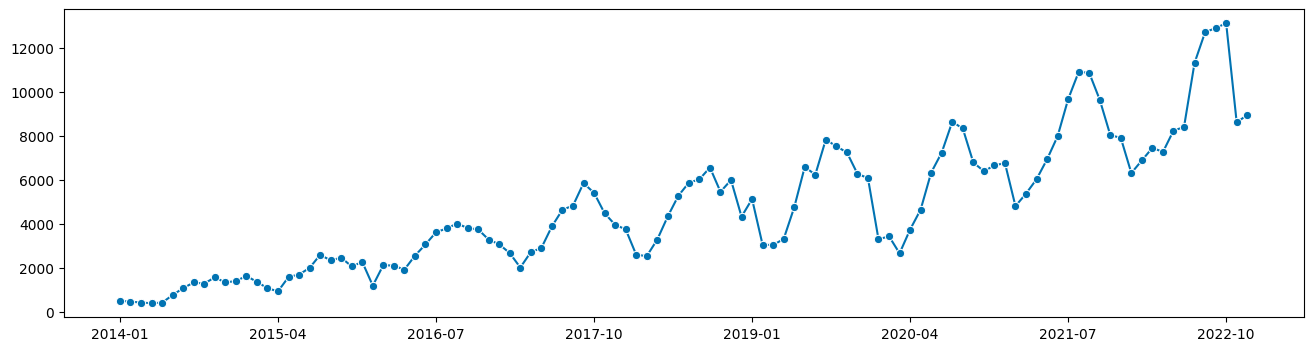

In [15]:
# Analisando a curva no tempo de análise
y = df_mês
plot_series(y)
plt.show()

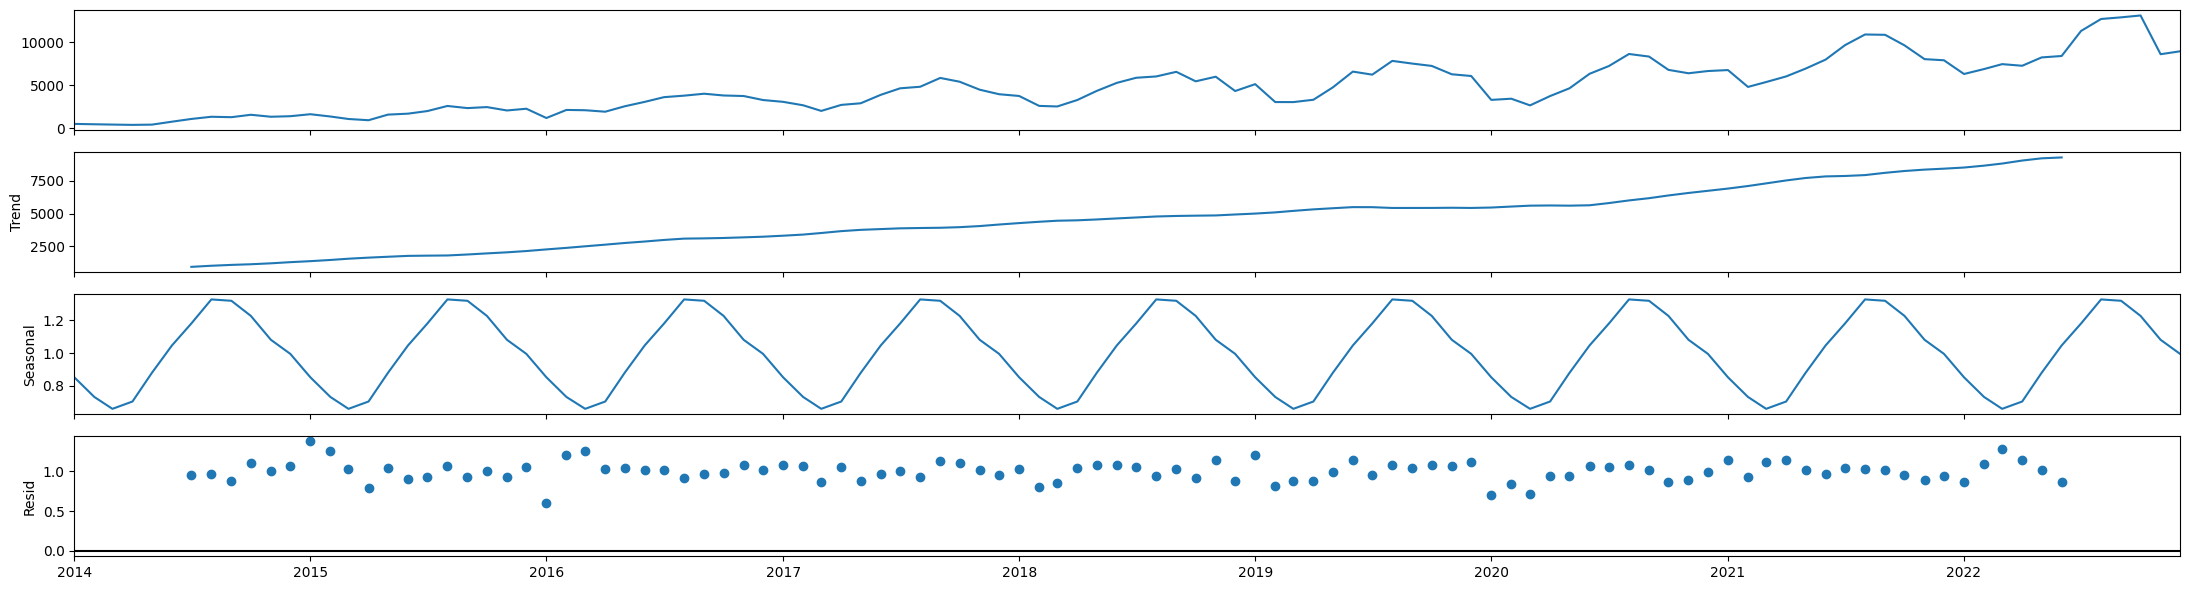

In [16]:
# Decomposição para observar tendência, sazonalidade e resíduo

y = df_mês
y.interpolate(inplace = True)
y.index = y.index.to_timestamp()
decomposition = seasonal_decompose(y, model="multiplicative")
decomposition.plot()
plt.show()

In [17]:
# Análise de Estacionariedade da série
# Se o valor p é > 0.05, a série não é estacionária. Uma solução é diferenciar a série.

resultado_adf(sm.tsa.adfuller(y))

Statistics=1.140, p-valor=0.99554173

**A série não é estacionária (falhamos em rejeitar H0)**

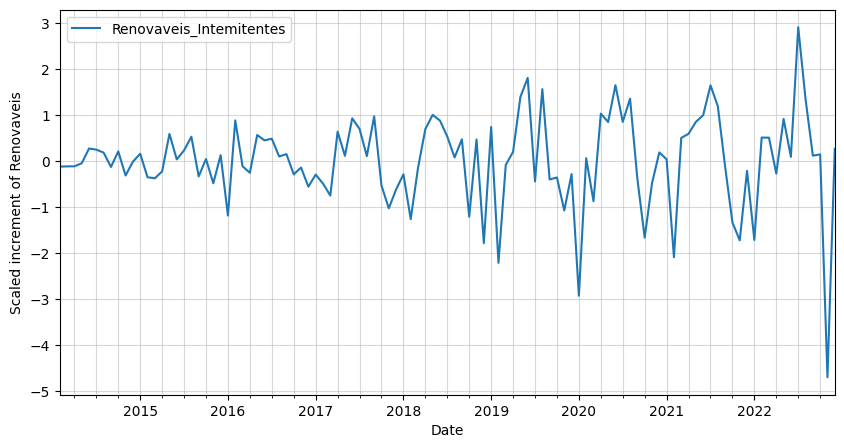

In [18]:
# Transformação através de Diferenciação da Série

y = df_mês
y = y.diff().dropna()

# Instantiate the scaler
scaler = StandardScaler()

# Transform data
scaled_values = scaler.fit_transform(y)

# Convert to dataframe
df_scaled = pd.DataFrame(scaled_values,
                         columns=y.columns,
                         index=y.index)

# Visualize data
df_scaled.plot(figsize=(10,5))
plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Scaled increment of Renovaveis')
plt.show()

In [19]:
# Análise de Estacionariedade da série
# Se o valor p é > 0.05, a série não é estacionária. Uma solução é diferenciar a série.

resultado_adf(sm.tsa.adfuller(df_scaled))

Statistics=-3.842, p-valor=0.00250662

**A série é estacionária (rejeitamos H0)**

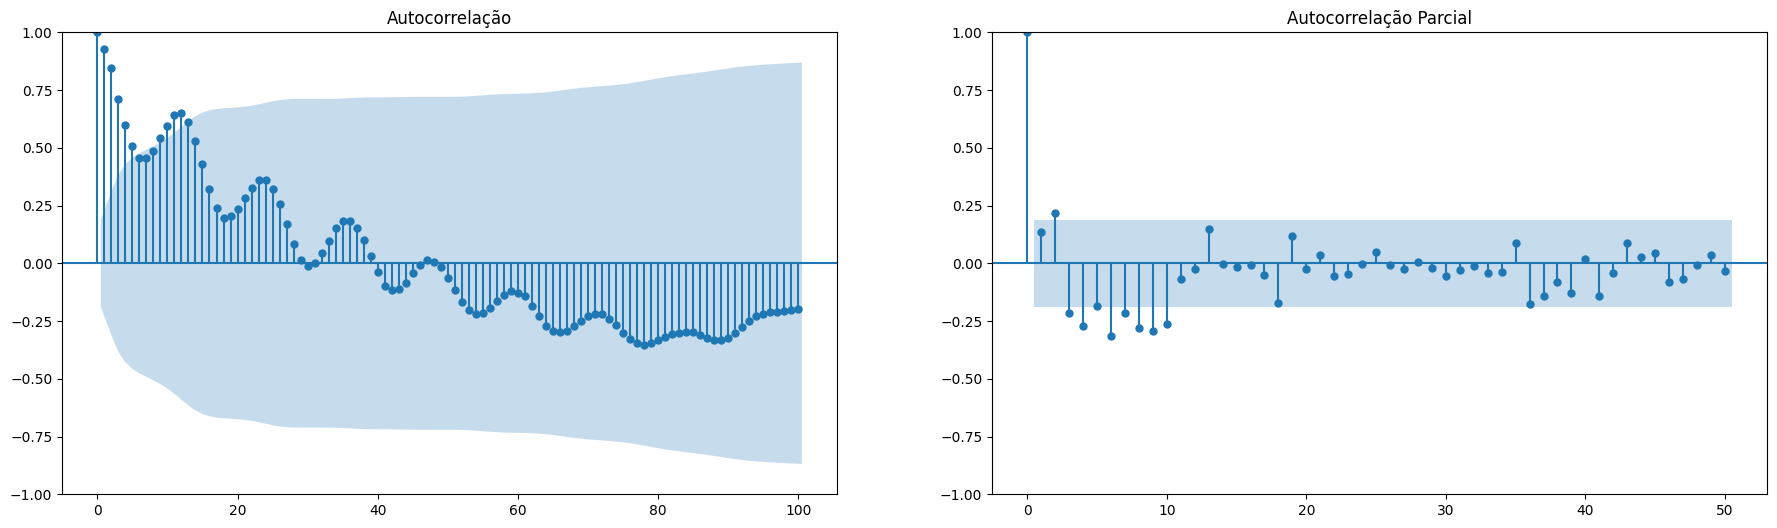

In [20]:
# ACF e PACF para determinar os parâmetros p e q dos modelos a serem analisados:
fig, axs = plt.subplots(1,2)

plot_acf(df_mês, lags=100, ax = axs[0], title="Autocorrelação")  # Para determinar p
plot_pacf(y, lags=50, ax = axs[1], title="Autocorrelação Parcial") # Para determinar q
plt.show()

## SARIMA Model com Statsmodel



In [21]:
y = df_mês
#y.index = y.index.to_timestamp()
y.index = pd.date_range(start=y.index.min(), periods=len(y), freq='M')

# Separação de treino e teste
y_train, y_test = temporal_train_test_split(y, test_size=24)

In [22]:
# Grid Search

# Definição de faixa de valores para p, d, q, P, D, Q, e m
#p_values = range(0, 3)  # Autoregressive order
#d_values = [1]         # Differencing order
#q_values = range(0, 3)  # Moving average order
#P_values = range(0, 3)  # Seasonal autoregressive order
#D_values = [1]  # Seasonal differencing order
#Q_values = range(0, 3)  # Seasonal moving average order
#m_values = [12]         # Seasonal period

# Valores Obtidos:	SARIMAX(2, 1, 1)x(1, 1, 1, 12)

p_values = [2]  # Autoregressive order
d_values = [1]         # Differencing order
q_values = [1]  # Moving average order
P_values = [1]  # Seasonal autoregressive order
D_values = [1]  # Seasonal differencing order
Q_values = [1]  # Seasonal moving average order
m_values = [12]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values,
                                            d_values,
                                            q_values,
                                            P_values,
                                            D_values,
                                            Q_values,
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")
best_params = None

# Aplicação de grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = sm.tsa.SARIMAX(y_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               maxiter=5000)
        result = model.fit(disp=False)
        aic = result.aic

        # Assegurar convergência do modelo
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)

            if aic < best_aic:
                best_aic = aic
                best_params = params

        else:
            print(order, seasonal_order, 'não converge')
    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(2, 1, 1) (1, 1, 1, 12) 1119.0931447212413
Best Parameters: (2, 1, 1, 1, 1, 1, 12)
Best AIC: 1119.0931447212413


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Train the optimal SARIMA model
model = sm.tsa.SARIMAX(y_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=24)
y_pred = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


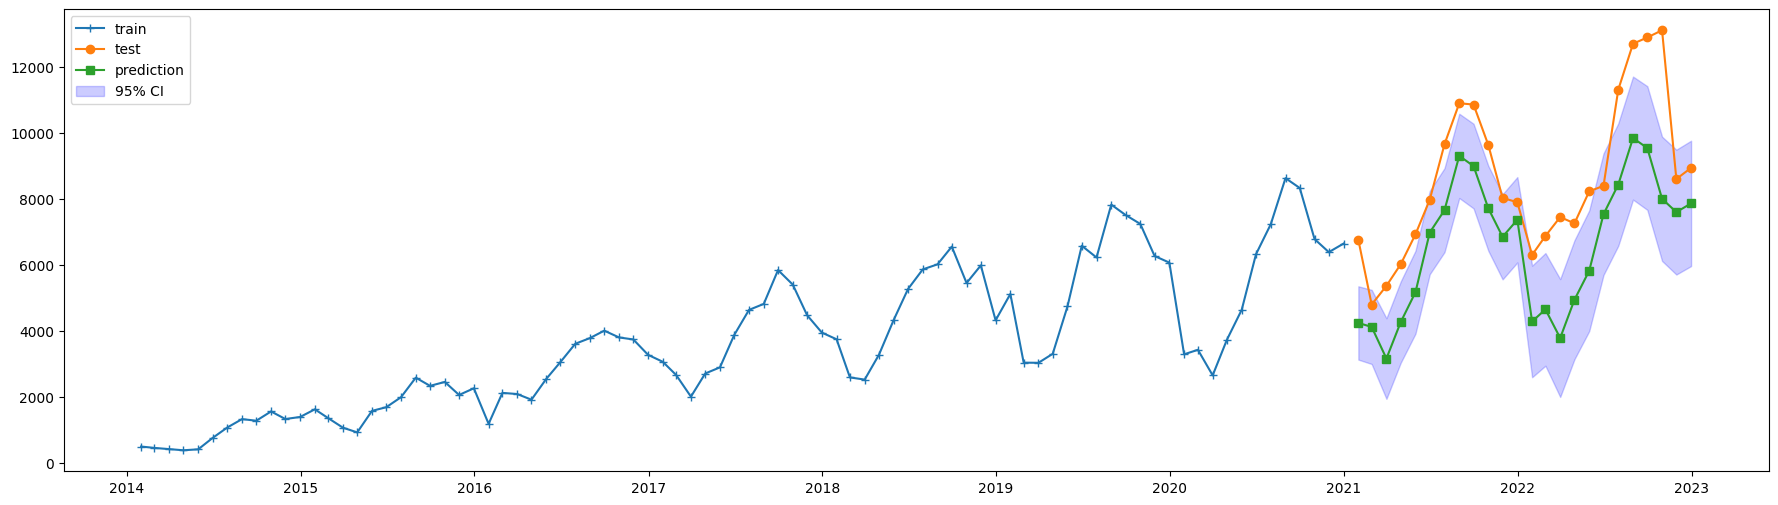

In [24]:
# Plot
plt.plot(y_train.index, y_train, label='train', marker='+')
plt.plot(y_test.index, y_test, label='test', marker='o')
plt.plot(y_test.index, y_pred, label='prediction', marker='s')
plt.fill_between(y_test.index, confidence_intervals['lower Renovaveis_Intemitentes'], confidence_intervals['upper Renovaveis_Intemitentes'], color='blue', alpha=0.2, label='95% CI')
plt.legend(loc='upper left')
plt.show()

In [25]:
# Show the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Renovaveis_Intemitentes   No. Observations:                   84
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -553.547
Date:                            Wed, 27 Sep 2023   AIC                           1119.093
Time:                                    01:59:41   BIC                           1132.669
Sample:                                01-31-2014   HQIC                          1124.492
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1080      0.171      0.630      0.529      -0.228       0.444
ar.L2          0.3750      0.161      2.336      0.019       0.060       0.690
ma.L1         -0.9579      0.096     -9.977      0.000      -1.146      -0.770
ar.S.L12      -0.9866      0.349     -2.827      0.005      -1.671      -0.303
ma.S.L12       0.9153      1.102      0.831      0.406      -1.244       3.075
sigma2      3.099e+05    2.4e+05      1.289      0.197   -1.61e+05    7.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                25.09
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               3.54   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.81e+14. Standard errors may be unstable.
"""

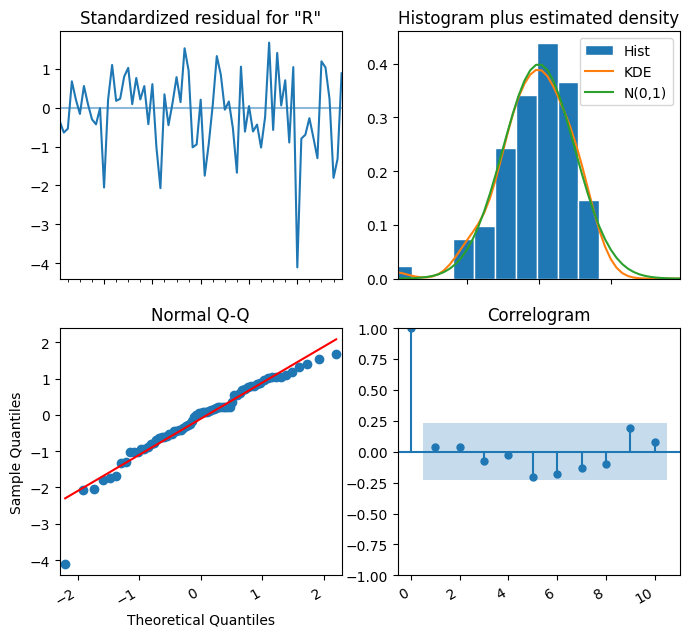

In [26]:
# Análise dos resíduos
fig = result.plot_diagnostics(figsize=(8, 8))
fig.autofmt_xdate()
plt.show()

In [27]:
# Métricas de Avaliação

# Predicted values and actual values
predicted_values = y_pred.values
actual_values = y_test.values.flatten()

evs = explained_variance_score(predicted_values, actual_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f'Score Variância: {evs}')
print(f'Erro Absoluto Médio (MAE): {mae}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse}')
print(f'Erro Percentual Absoluto Médio (MAPE): {mape}')

Score Variância: 0.7342915086649537
Erro Absoluto Médio (MAE): 2031.3264172640327
Raiz do Erro Quadrático Médio (RMSE): 2277.137322744723
Erro Percentual Absoluto Médio (MAPE): 23.96878662107287


In [28]:
# Aplicando modelo com transformação da série

y = df_mês

# Transformação com Log
y = np.log(y)
y.dropna(inplace=True)

y.index = pd.date_range(start=y.index.min(), periods=len(y), freq='M')

# Separação de treino e teste
y_train, y_test = temporal_train_test_split(y, test_size=24)

# Train the optimal SARIMA model
model = sm.tsa.SARIMAX(y_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=24)
y_pred = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

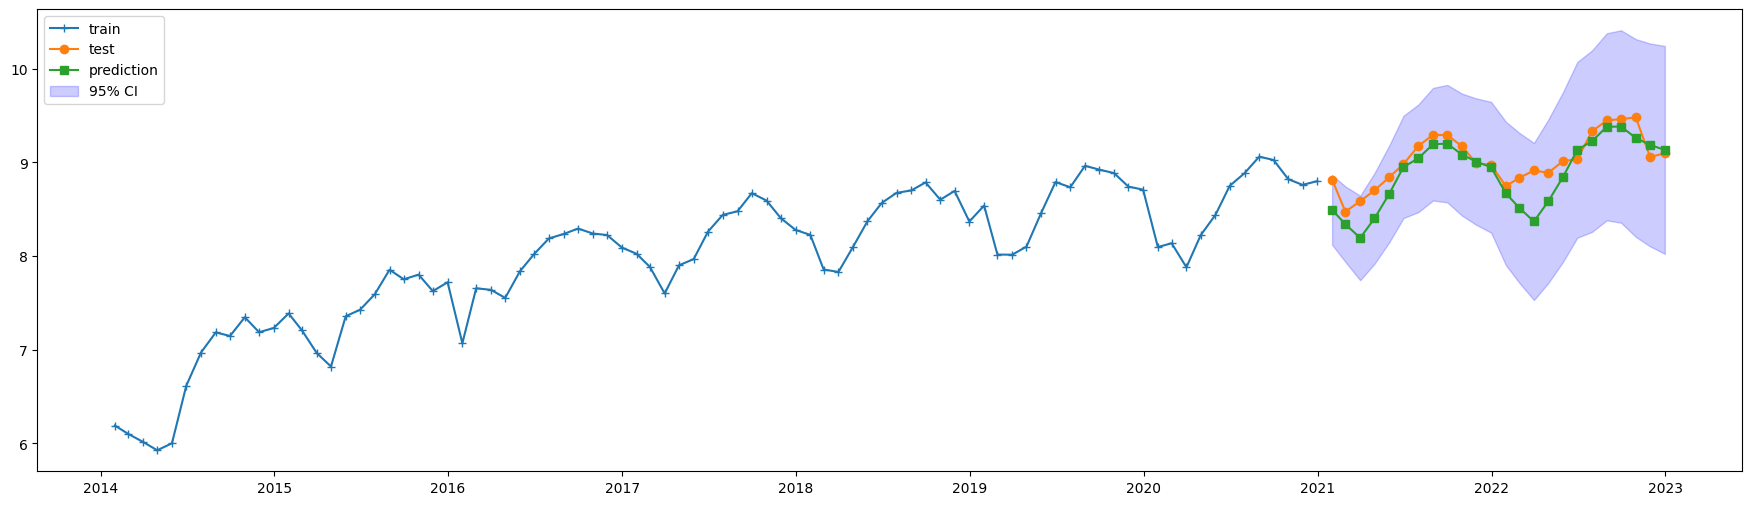

In [29]:
# Plot
plt.plot(y_train.index, y_train, label='train', marker='+')
plt.plot(y_test.index, y_test, label='test', marker='o')
plt.plot(y_test.index, y_pred, label='prediction', marker='s')
plt.fill_between(y_test.index, confidence_intervals['lower Renovaveis_Intemitentes'], confidence_intervals['upper Renovaveis_Intemitentes'], color='blue', alpha=0.2, label='95% CI')
plt.legend(loc='upper left')
plt.show()

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Renovaveis_Intemitentes   No. Observations:                   84
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  14.184
Date:                            Wed, 27 Sep 2023   AIC                            -16.367
Time:                                    01:59:44   BIC                             -2.791
Sample:                                01-31-2014   HQIC                           -10.969
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.612      0.011      0.991      -1.194       1.207
ar.L2          0.1334      0.386      0.345      0.730      -0.624       0.891
ma.L1         -0.5903      0.575     -1.026      0.305      -1.718       0.537
ar.S.L12      -0.0610      0.307     -0.198      0.843      -0.664       0.542
ma.S.L12      -0.5738      0.380     -1.509      0.131      -1.319       0.171
sigma2         0.0361      0.007      5.304      0.000       0.023       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 8.47
Prob(Q):                              0.47   Prob(JB):                         0.01
Heteroskedasticity (H):               0.43   Skew:                            -0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

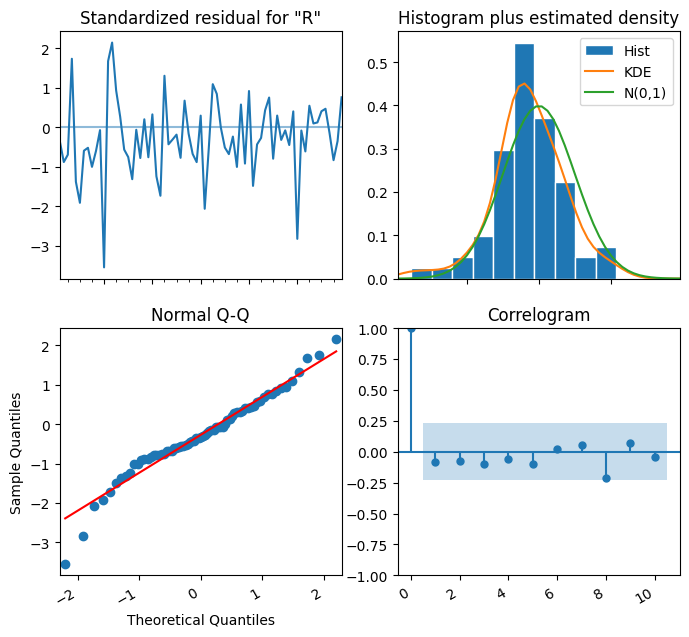

In [31]:
# Análise dos resíduos
fig = result.plot_diagnostics(figsize=(8, 8))
fig.autofmt_xdate()
plt.show()

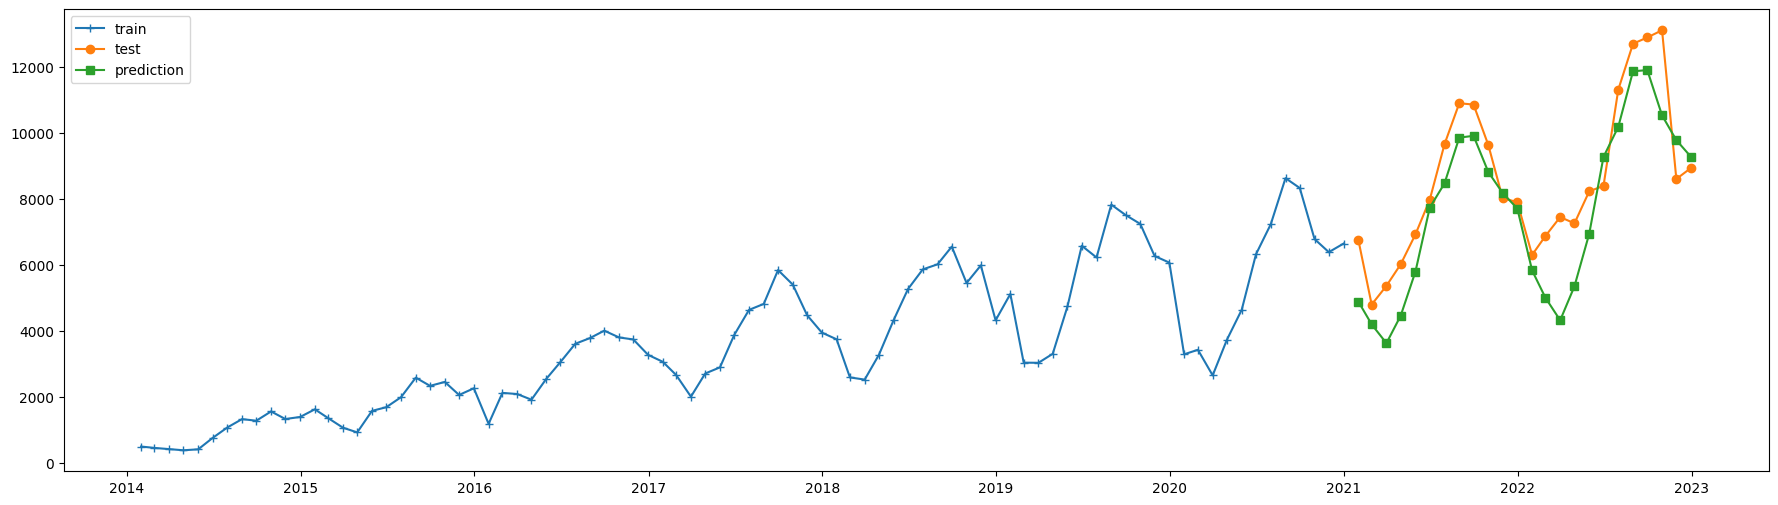

In [32]:
# Transformação Inversa

y_train_exp = np.exp(y_train)
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)
confidence_intervals_exp = np.exp(confidence_intervals)

# Plot
plt.plot(y_train_exp.index, y_train_exp, label='train', marker='+')
plt.plot(y_test_exp.index, y_test_exp, label='test', marker='o')
plt.plot(y_test_exp.index, y_pred_exp, label='prediction', marker='s')
#plt.fill_between(y_test_exp.index, confidence_intervals_exp['lower Renovaveis_Intemitentes'], confidence_intervals_exp['upper Renovaveis_Intemitentes'], color='blue', alpha=0.2, label='95% CI')
plt.legend(loc='upper left')
plt.show()

In [33]:
# Métricas de Avaliação

# Predicted values and actual values
predicted_values = y_pred_exp.values
actual_values = y_test_exp.values.flatten()

evs = explained_variance_score(predicted_values, actual_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f'Score Variância: {evs}')
print(f'Erro Absoluto Médio (MAE): {mae}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse}')
print(f'Erro Percentual Absoluto Médio (MAPE): {mape}')

Score Variância: 0.8429957244181259
Erro Absoluto Médio (MAE): 1168.7395223675405
Raiz do Erro Quadrático Médio (RMSE): 1375.7239250336638
Erro Percentual Absoluto Médio (MAPE): 14.655059211386806


In [34]:
## Aplicação do Modelo

# Treinamento do Modelo com Toda a Série Temporal
model = sm.tsa.SARIMAX(y,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Definindo o Horizonte de Previsão
future_dates = pd.date_range(start=y.index[-1], periods=10, freq='M')[1:]  # 9 meses à frente

# Realizando Previsões
forecast = result.get_forecast(steps=9)
y_pred = forecast.predicted_mean

# Revertendo a Transformação
future_forecast_exp = np.exp(y_pred)

In [35]:
df_atual.index = df_atual.index.to_timestamp()
df_atual.index = pd.date_range(start=df_atual.index.min(), periods=len(df_atual), freq='M')

In [36]:
# Visualização com Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_atual.index, y=df_atual.iloc[:, 0], mode='lines+markers', name='Real'))
fig.add_trace(go.Scatter(x=y.index, y=np.exp(y.iloc[:, 0]), mode='lines+markers', name='Original Series'))
#fig.add_trace(go.Scatter(x=future_dates, y=future_forecast_exp.iloc[:, 0], mode='lines+markers', name='Future Forecasts'))
fig.add_trace(go.Scatter(x=future_dates, y=future_forecast_exp, mode='lines+markers', name='Future Forecasts'))

fig.update_layout(title='Original Series, Real Data and Future Forecasts',
                   xaxis_title='Mês/Ano',
                   yaxis_title='Geração Renovável Intermitente')
fig.show()

## SARIMA Model com AutoARIMA


In [37]:
y = df_mês
#y.index = y.index.to_timestamp()
y.index = pd.date_range(start=y.index.min(), periods=len(y), freq='M')

# Separação de treino e teste
y_train, y_test = temporal_train_test_split(y, test_size=24)

# Estratégia de modelagem utilizando o auto_arima do pmdarima
model = pm.auto_arima(y_train,
                      seasonal=True,  # Se a série temporal é sazonal
                      m=12,  # A periodicidade da série temporal (se sazonal)
                      suppress_warnings=True,  # Suprimir warnings
                      stepwise=True)  # Usar o algoritmo stepwise para encontrar o melhor modelo

model.fit(y_train)

y_pred, conf_int = model.predict(n_periods=len(y_test), return_conf_int=True)

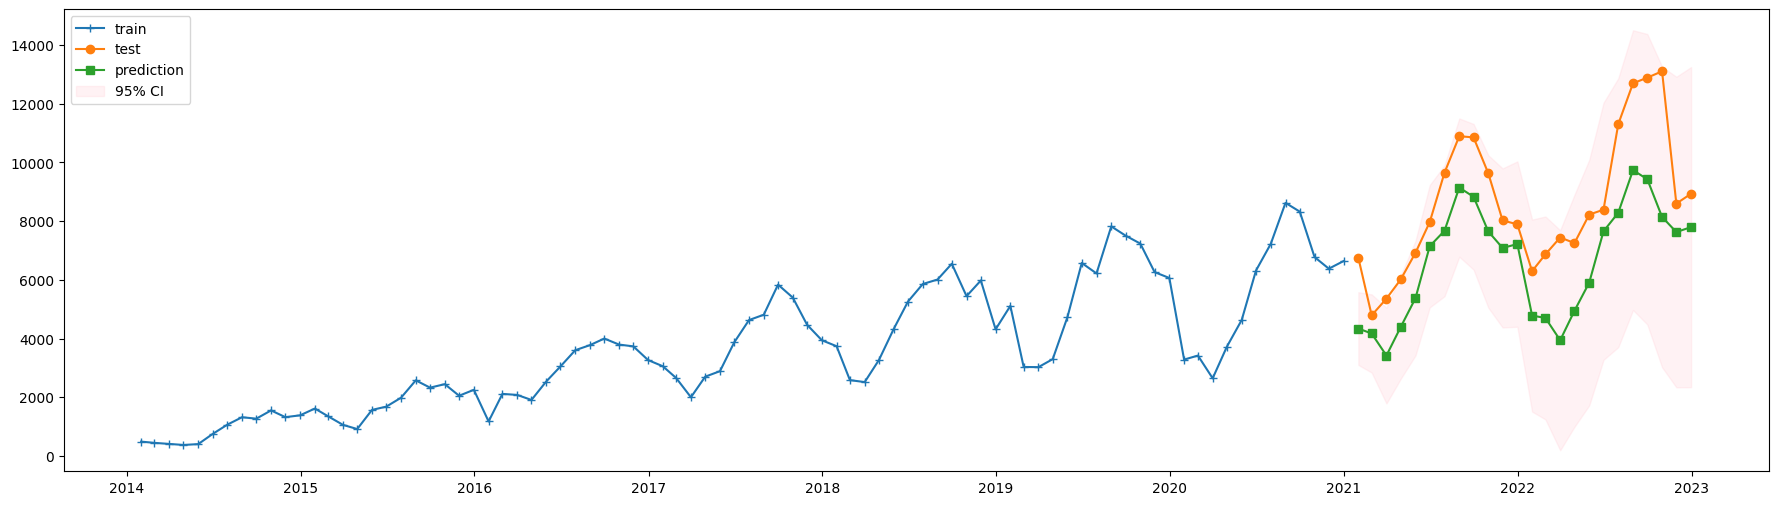

In [38]:
# Plot
plt.plot(y_train.index, y_train, label='train', marker='+')
plt.plot(y_test.index, y_test, label='test', marker='o')
plt.plot(y_test.index, y_pred, label='prediction', marker='s')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.2, label='95% CI')
plt.legend(loc='upper left')
plt.show()

In [39]:
# Summary com pmdarima
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -559.014
Date:                            Wed, 27 Sep 2023   AIC                           1124.028
Time:                                    02:00:06   BIC                           1130.816
Sample:                                01-31-2014   HQIC                          1126.728
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6066      0.111     -5.441      0.000      -0.825      -0.388
ar.S.L12      -0.2819      0.162     -1.739      0.082      -0.600       0.036
sigma2      3.996e+05   5.38e+04      7.431      0.000    2.94e+05    5.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.28
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

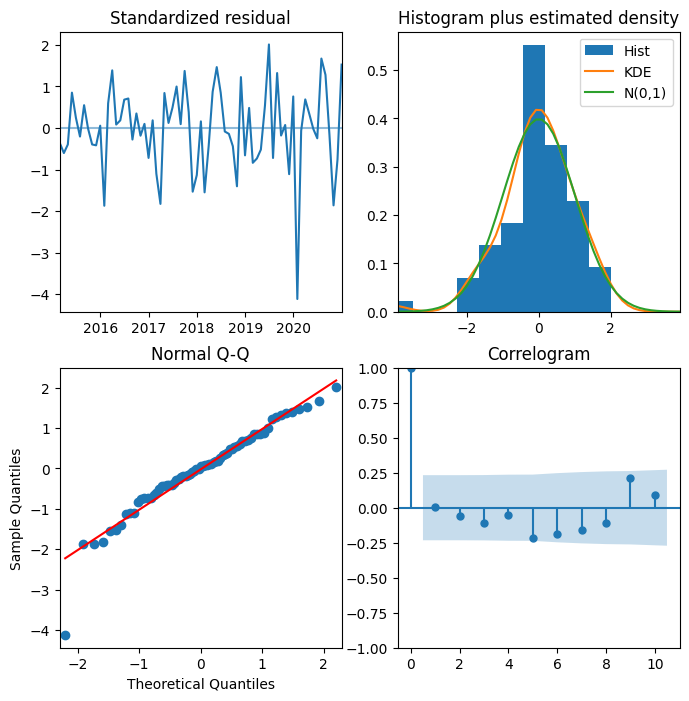

In [40]:
# Análise dos resíduos
model.plot_diagnostics(figsize=(8,8))
plt.show()

In [41]:
# Métricas de Avaliação

# Predicted values and actual values
predicted_values = y_pred.values
actual_values = y_test.values.flatten()

evs = explained_variance_score(predicted_values, actual_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f'Score Variância: {evs}')
print(f'Erro Absoluto Médio (MAE): {mae}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse}')
print(f'Erro Percentual Absoluto Médio (MAPE): {mape}')

Score Variância: 0.700566757811782
Erro Absoluto Médio (MAE): 1972.817889831291
Raiz do Erro Quadrático Médio (RMSE): 2227.9558021892763
Erro Percentual Absoluto Médio (MAPE): 22.940073181266385


In [42]:
# Aplicando modelo com transformação da série

y = df_mês

# Transformação com Log
y = np.log(y)
y.dropna(inplace=True)

y.index = pd.date_range(start=y.index.min(), periods=len(y), freq='M')

# Separação de treino e teste
y_train, y_test = temporal_train_test_split(y, test_size=24)

# Estratégia de modelagem utilizando o auto_arima do pmdarima
model = pm.auto_arima(y_train,
                      seasonal=True,  # Se a série temporal é sazonal
                      m=12,  # A periodicidade da série temporal (se sazonal)
                      suppress_warnings=True,  # Suprimir warnings
                      stepwise=True)  # Usar o algoritmo stepwise para encontrar o melhor modelo

model.fit(y_train)

y_pred, conf_int = model.predict(n_periods=len(y_test), return_conf_int=True)

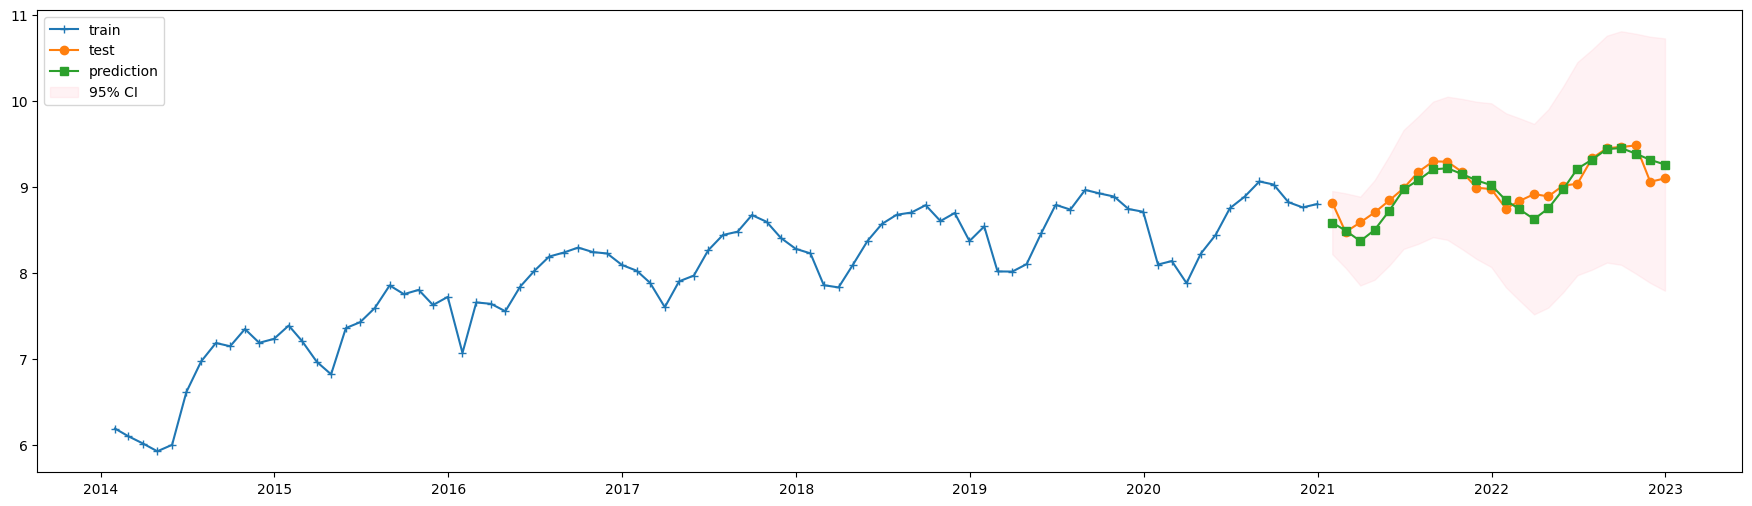

In [43]:
# Plot com modelagem via pmdarima
plt.plot(y_train.index, y_train, label='train', marker='+')
plt.plot(y_test.index, y_test, label='test', marker='o')
plt.plot(y_test.index, y_pred, label='prediction', marker='s')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.2, label='95% CI')
plt.legend(loc='upper left')
plt.show()

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                  14.893
Date:                              Wed, 27 Sep 2023   AIC                            -21.786
Time:                                      02:01:08   BIC                            -12.110
Sample:                                  01-31-2014   HQIC                           -17.899
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3702      0.085     -4.369      0.000      -0.536      -0.204
ar.S.L12       0.9781      0.055     17.774      0.000       0.870       1.086
ma.S.L12      -0.7827      0.257     -3.043      0.002      -1.287      -0.279
sigma2         0.0345      0.007      4.716      0.000       0.020       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.28
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               0.51   Skew:                            -0.17
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

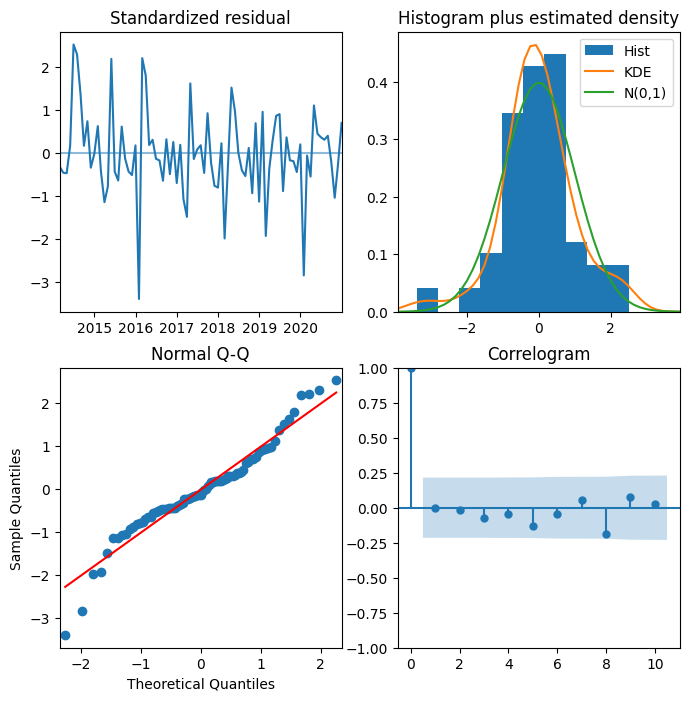

In [45]:
# Análise dos resíduos
model.plot_diagnostics(figsize=(8,8))
plt.show()

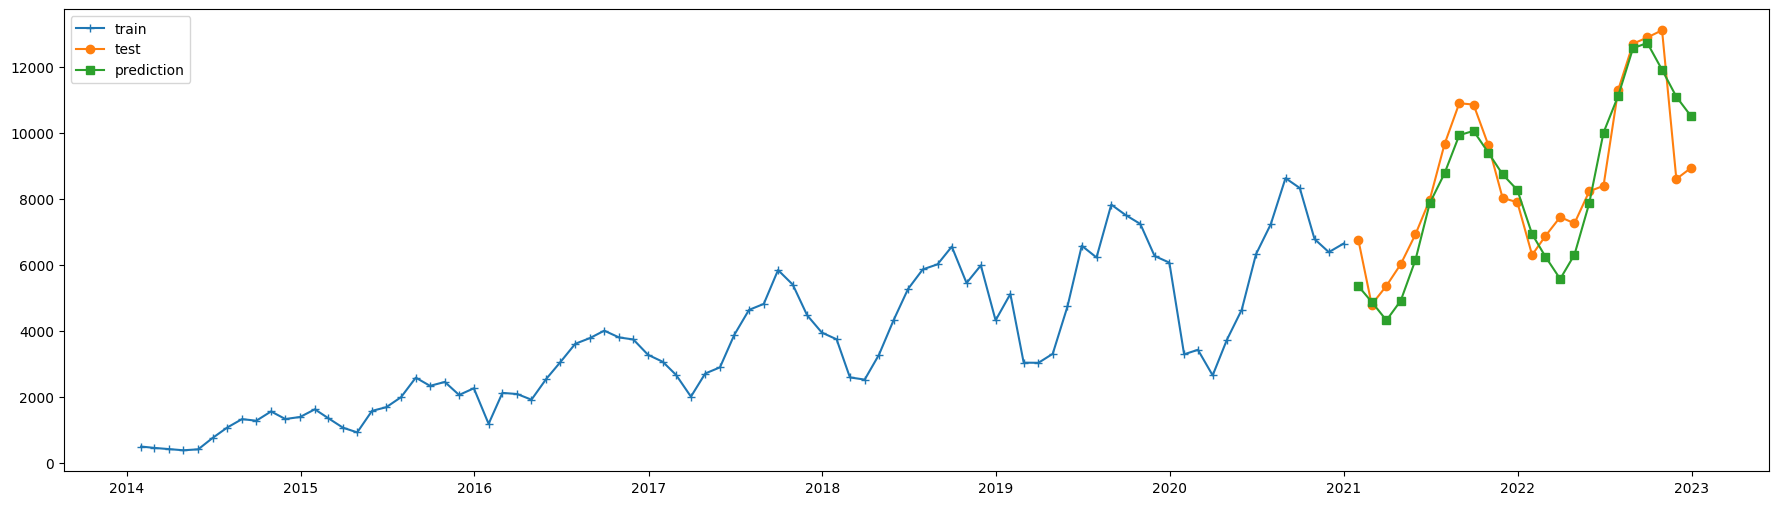

In [46]:
# Transformação Inversa

y_train_exp = np.exp(y_train)
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

#plot_series(y_train_exp, y_test_exp, y_pred_exp, labels=['train','test','pred'])
#plt.legend()
#plt.show()

# Plot
plt.plot(y_train_exp.index, y_train_exp, label='train', marker='+')
plt.plot(y_test_exp.index, y_test_exp, label='test', marker='o')
plt.plot(y_test_exp.index, y_pred_exp, label='prediction', marker='s')
plt.legend(loc='upper left')
plt.show()

In [47]:
# Métricas de Avaliação

# Predicted values and actual values
predicted_values = y_pred_exp.values
actual_values = y_test_exp.values.flatten()

evs = explained_variance_score(predicted_values, actual_values)
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f'Score Variância: {evs}')
print(f'Erro Absoluto Médio (MAE): {mae}')
print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse}')
print(f'Erro Percentual Absoluto Médio (MAPE): {mape}')

Score Variância: 0.8359937820378529
Erro Absoluto Médio (MAE): 845.0419729707686
Raiz do Erro Quadrático Médio (RMSE): 1042.44925390587
Erro Percentual Absoluto Médio (MAPE): 10.6265765427503


In [48]:
## Aplicação do Modelo

# Treinamento do Modelo com Toda a Série Temporal
model.fit(y)  # 'y' é toda a sua série temporal

# Definindo o Horizonte de Previsão
future_dates = pd.date_range(start=y.index[-1], periods=10, freq='M')[1:]  # 9 meses à frente

# Realizando Previsões
future_forecast, conf_int = model.predict(n_periods=9, return_conf_int=True)

# Revertendo a Transformação
future_forecast_exp = np.exp(future_forecast)

In [49]:
#df_atual.index = df_atual.index.to_timestamp()
df_atual.index = pd.date_range(start=df_atual.index.min(), periods=len(df_atual), freq='M')

In [50]:
# Visualização com Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_atual.index, y=df_atual.iloc[:, 0], mode='lines+markers', name='Real'))
fig.add_trace(go.Scatter(x=y.index, y=np.exp(y.iloc[:, 0]), mode='lines+markers', name='Original Series'))
#fig.add_trace(go.Scatter(x=future_dates, y=future_forecast_exp.iloc[:, 0], mode='lines+markers', name='Future Forecasts'))
fig.add_trace(go.Scatter(x=future_dates, y=future_forecast_exp, mode='lines+markers', name='Future Forecasts'))

fig.update_layout(title='Original Series, Real Data and Future Forecasts',
                   xaxis_title='Mês/Ano',
                   yaxis_title='Geração Renovável Intermitente')
fig.show()

## Conclusões


*   **Resultados de Métricas**

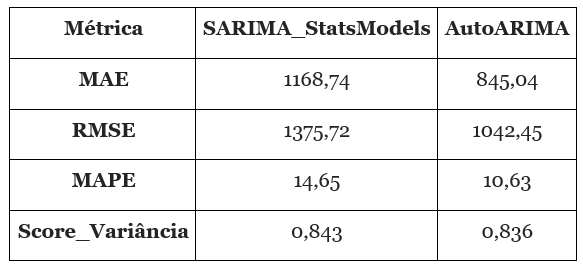



*   **Teste com Modelagem pelo SARIMA da biblioteca Statsmodel**:

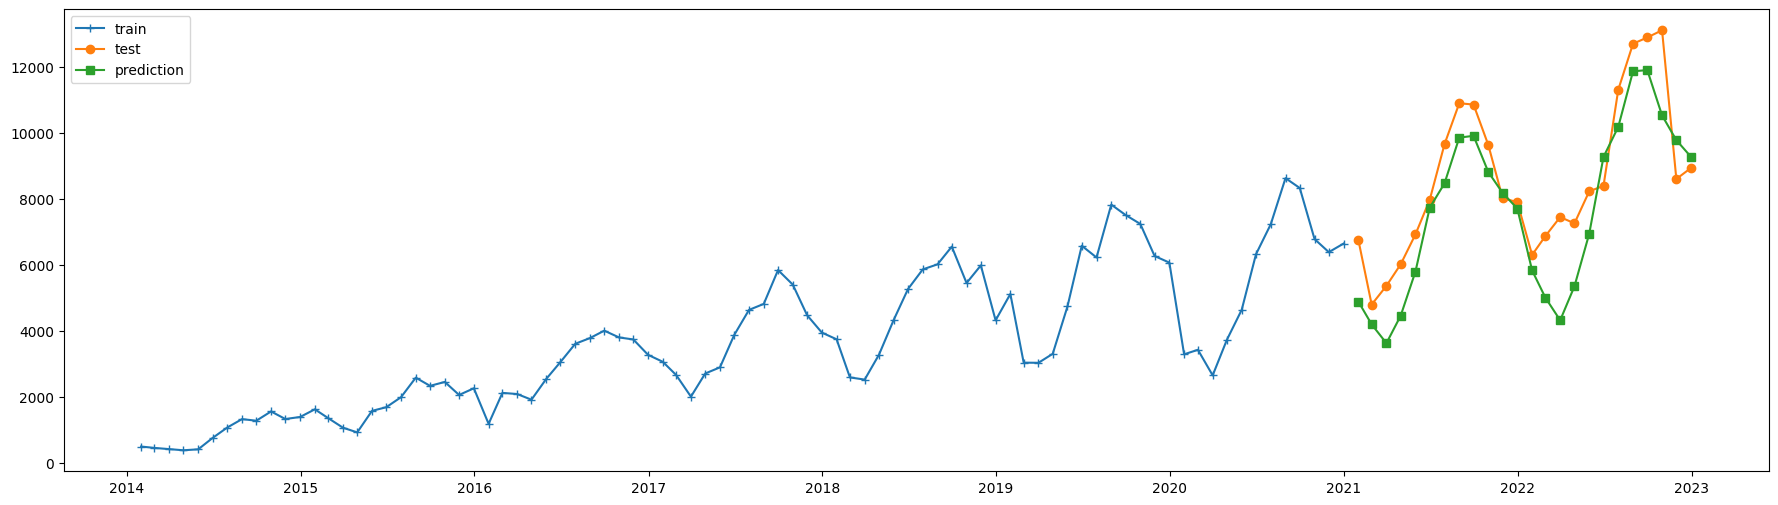

*   **Teste com Modelagem pelo AutoARIMA da biblioteca pmdarima**:

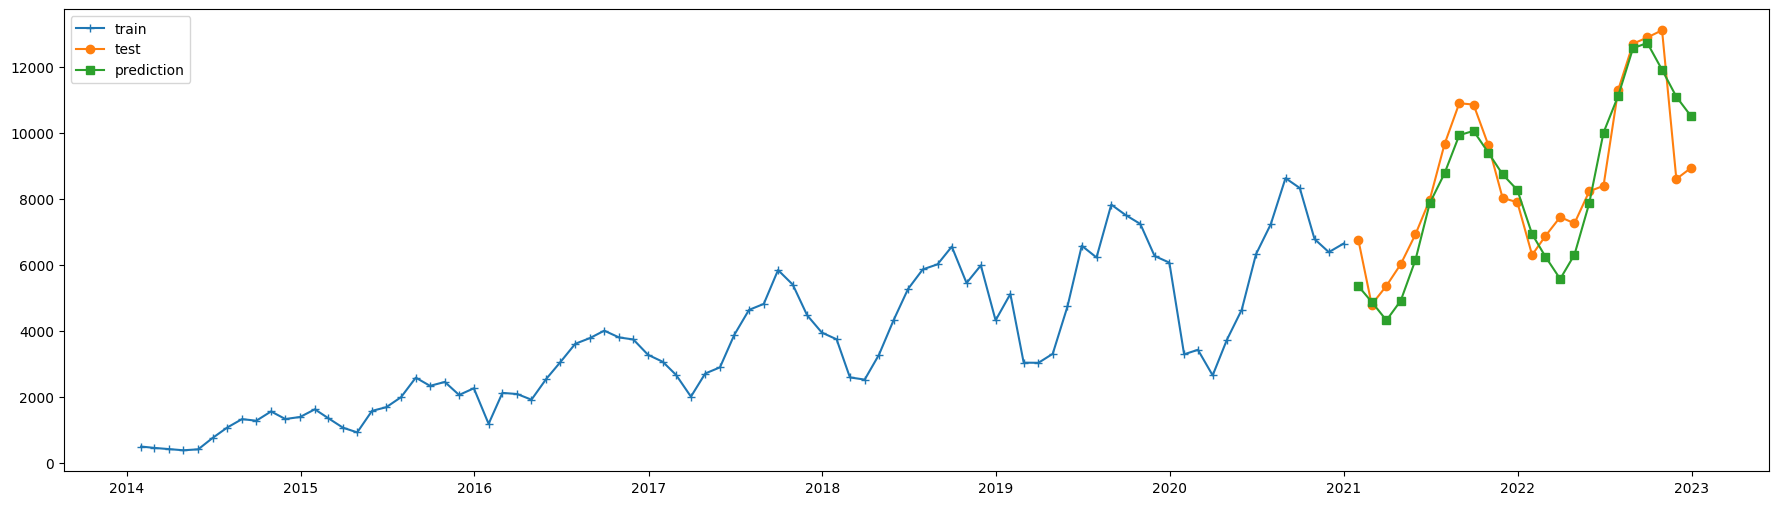

*   **Previsão de dados futuros com Modelagem pelo SARIMA da biblioteca Statsmodel**:

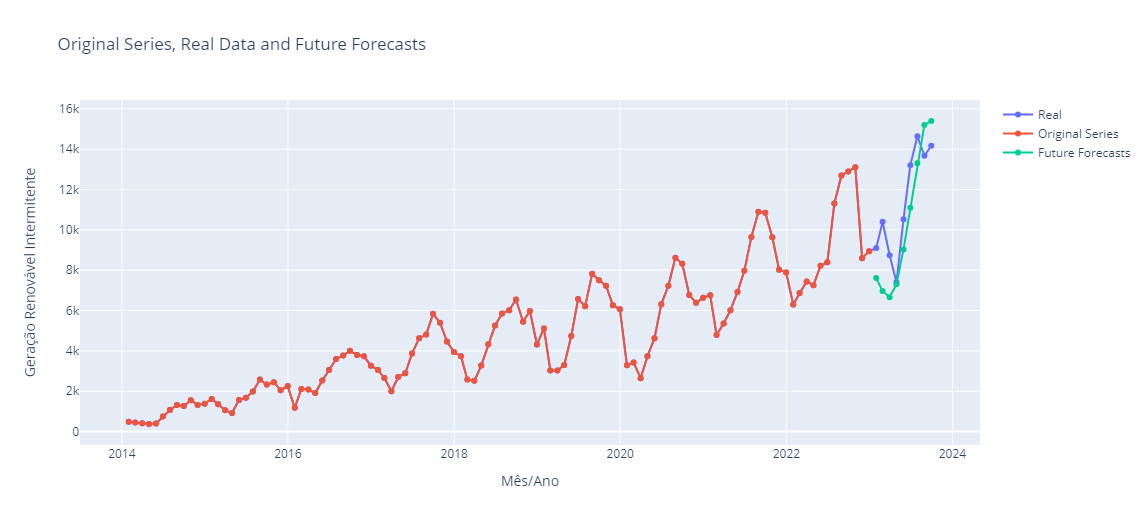

*   **Previsão de dados futuros com Modelagem pelo AutoARIMA da biblioteca pmdarima**:

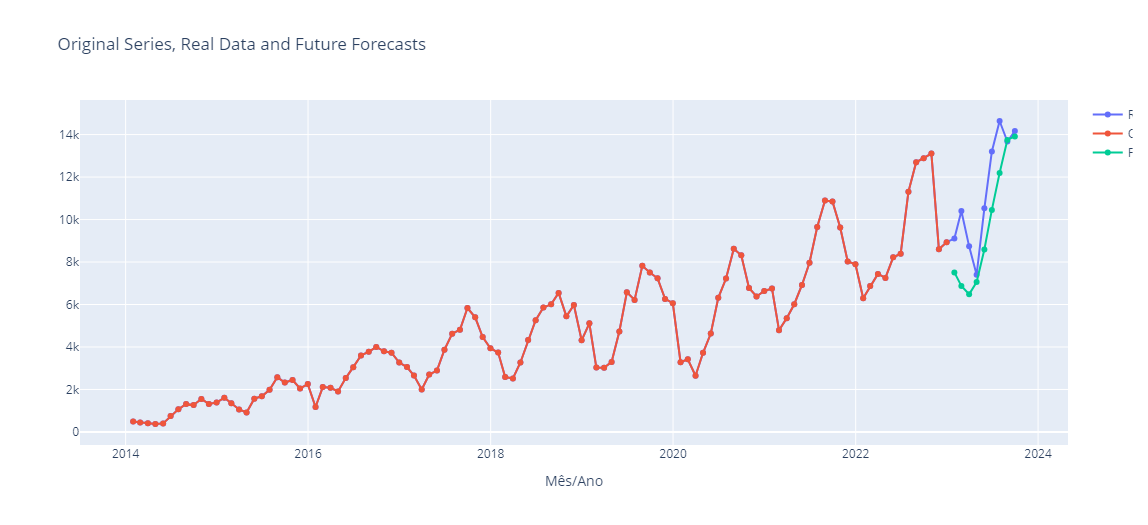

A partir dos resultados obtidos, identica-se o modelo AutoARIMA apresenta resultados um pouco melhor que aqueles derivados do SARIMA.
Destaca-se que o modelo pode ser refinado através de variáveis exógenas.
Outros modelos mais avançados poderiam ser aplicados de forma a obter resultados mais precisos.
Adicionalmente, uma outra análise que possa ser realizada é a predição com granularidade horária, a qual é importante para mitigar a exposição ao Preço de Liquidação de Diferenças (PLD). O PLD é um valor calculado semanalmente pela Câmara de Comercialização de Energia Elétrica (CCEE) no Brasil. Ele reflete o custo marginal de operação do Sistema Interligado Nacional (SIN) e é utilizado para liquidar as diferenças entre os montantes de energia elétrica contratados e os efetivamente gerados ou consumidos pelos agentes de mercado de energia elétrica. Tal parâmetro funciona como um sinal econômico que reflete as condições de oferta e demanda de energia elétrica no mercado de curto prazo, influenciando decisões de operação, consumo, e investimentos dos agentes do setor elétrico. Quando há escassez de energia, o PLD tende a ser mais alto, refletindo o maior custo de geração. Agentes que têm uma diferença entre a energia contratada e a efetivamente consumida ou gerada estão expostos ao PLD. Se geram ou consomem mais energia do que o contratado, precisam comprar ou vender a diferença no mercado spot, pagando ou recebendo o valor do PLD. Neste contexto, uma das estratégias para reduzir a exposição ao PLD é utilizar modelos preditivos para antecipar padrões de geração e ajustar estratégias operacionais e de contratação de energia.